Проект 4. Компьютер говорит нет!

### Цель проекта:
* Построение модели, предсказывающей вероятность дефолта по кредиту на основе данных по клиенту

### Алгоритм действий:
* Загружаем файл train.
* Делаем разведку признаков. Используем визуализацию, очистку и поиск выбросов. Удаляем, заменяем, где нужно.
* Делим датасет на обучающую и отложенную части
* Балансируем обучающую часть.
* На полученном массиве данных обучаем модель.
* Проверяем её способность к прогнозам на отложенной выборке.
* Если результат не устраивает, повторяем п. 2-6
* Если результат устраивает, передаем обученной модели массив данных из test. Получаем прогноз, оформляем его в файл submission, отправляем на соревнование.

In [1]:
import pandas as pd
import numpy as np
from pandas import Series

import pandas_profiling
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures

import imblearn
from imblearn.over_sampling import SMOTE

### Загрузка датасета

In [54]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [55]:
train = pd.read_csv('train.csv', encoding = 'ISO-8859-1', low_memory = False)
test = pd.read_csv("test.csv", encoding = 'ISO-8859-1', low_memory = False)
submission = pd.read_csv('sample_submission.csv', encoding = 'ISO-8859-1', low_memory = False)

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

### Описания полей

**client_id** - идентификатор клиента  
**education** - уровень образования  
**sex** - пол заемщика  
**age** - возраст заемщика  
**car** - флаг наличия автомобиля  
**car_type** - флаг автомобиля иномарки  
**decline_app_cnt** - количество отказанных прошлых заявок  
**good_work** - флаг наличия “хорошей” работы  
**bki_request_cnt** - количество запросов клиента в БКИ о своей кредитной истории  
**home_address** - категоризатор домашнего адреса  
**work_address** - категоризатор рабочего адреса  
**income** - доход заемщика  
**foreign_passport** - наличие загранпаспорта  
**sna** - связь заемщика с клиентами банка  
**first_time** - давность наличия информации о заемщике  
**score_bki** - скоринговый балл по данным из БКИ  
**region_rating** - рейтинг региона  
**app_date** - дата подачи заявки  
**default** - флаг дефолта по кредит  

### Предварительное изучение признаков

In [7]:
profile = ProfileReport(train)
profile

Pandas ProfileReport показал, что пропуски (307) есть только в признаке образования.
Уже на этих графиках видно некоторое смещение данных возраста, дохода, запросов на кредит, а также отказов в кредите.  
Видны сильные корреляции между рабочим и домашним адресом, между наличем машины и типом машины, а также сильная отрицательная корреляция между связью заемщика и первой записью о заемщике в банке.  
Видна большая диспропорция в целевой переменной.

### Создадим функции

In [57]:
# Функция расчета точности, а также составляющих матрицы ошибок
def calc_accuracy(y_true, y_pred):
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    acc = (TP + TN) / (P + N)
    return acc, TP, TN, P, N

In [58]:
# Функция, присвающая выбросам значения в межквартильном пределе  
def cut_IQR(column, data):
    Q25 = train[column].quantile(0.25)
    Q75 = train[column].quantile(0.75)
    IQR = Q75 - Q25
    l_bound = Q25 - 1.5*IQR
    r_bound = Q75 + 1.5*IQR

    train[column] = train[column].apply(lambda x: r_bound if x  >=  r_bound else x)
    train[column] = train[column].apply(lambda x: l_bound if x  <=  l_bound else x)

In [59]:
# Считаем метрики модели
def metrics(y_test, probs, y_pred_test):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    f1_test_n = f1_score(y_test, y_pred_test)
    print('f1 score:=',round(f1_test_n,4))

    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    print('precision: {:.4f}\nrecall: {:.4f}'.format(precision, recall))

    calc_accuracy(y_test, y_pred_test)
    acc, TP, TN, P, N = calc_accuracy(y_test, y_pred_test)
    print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {:.4f}'.format(TP, TN, P, N, acc))

    conf_mat = confusion_matrix(y_test, y_pred_test)
    print('Confusion matrix:\n{}'.format(conf_mat))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
    disp.plot()

### Создадим наивную модель с минимальными преобразованиями

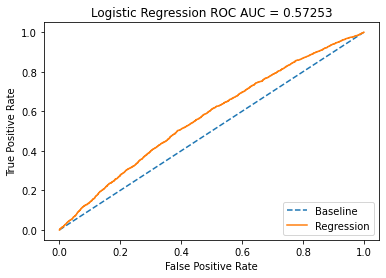

f1 score:= 0.0
precision: 0.0000
recall: 0.0000
TP = 0
TN = 12822
P = 1877
N = 12822
acc = 0.8723
Confusion matrix:
[[12822     0]
 [ 1877     0]]


/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


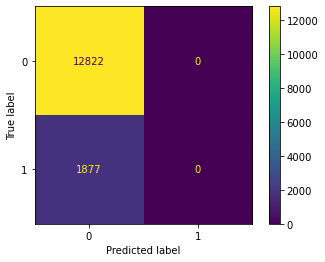

In [11]:
train_naive = train.copy()

# Просто удалим пропуски 
train_naive.dropna(inplace=True)

# Разделим признаки на типы
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address','sna','first_time']
# Числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']
# Пока не будем использовать app_date, поскольку это требует дальнейшей обработки 

# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    train_naive[column] = label_encoder.fit_transform(train_naive[column])
    
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    train_naive[column] = label_encoder.fit_transform(train_naive[column])
    
#  Создаем dummy-переменные образования  
edu_dummies = pd.get_dummies(train_naive['education'])
train_naive = train_naive.drop('education', axis=1).join(edu_dummies)
cat_cols = ['home_address', 'work_address','sna','first_time']

# Помещаем данные по типу в матрицу переменных
X_cat_naive = OneHotEncoder(sparse = False).fit_transform(train_naive[cat_cols].values)
X_num_naive = train_naive[num_cols].values

# Объединяем три типа данных в одну матрицу значений Х
X_naive = np.hstack([X_num_naive, train_naive[bin_cols].values, X_cat_naive,])
y_naive = train_naive['default'].values

# Разделим данные для обучения
X_train, X_test, y_train, y_test = train_test_split(X_naive, y_naive, test_size=0.20, random_state=42)

# Обучаем модель
model = LogisticRegression()
model.fit(X_train, y_train)

# Предсказываем на тестовой выборке
y_pred_test = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]

# Смотрим на результат
metrics(y_test, probs, y_pred_test)

Наивная модель не смогла выявить истинных положительных. ROC AUC = 0.57253. Это будет отправной точкой для улучшения модели.


### Предварительное разделение признаков

В нашем датасете есть признак app_date, который содержит даты:

In [60]:
# пребразуем значения признака в формат datetime
train.app_date = pd.to_datetime(train.app_date)
print('First app:',train.app_date.min())
print('Last app:', train.app_date.max())

First app: 2014-01-01 00:00:00
Last app: 2014-04-30 00:00:00


app_date содержит даты от 1 января до 30 апреля 2014 г. Это, видимо, данные заявок на кредит, которые были собраны за это время.  
Создадим несколько категориальных и бинарных признаков из app_date:

In [61]:
# Создадим бинарный признак для заявок в выходные
train['is_weekend'] = train.app_date.dt.weekday > 4
# Создадим категориальный признак для месяцев заявок
train['month'] = train.app_date.dt.month
# Создадим категориальный призек
train['day'] = train.app_date.dt.weekday
# Создадим бинарный признак для конца месяца
train['start_month'] = train.app_date.dt.day < 7
train

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0          25905 2014-02-01       SCH   M   62   Y        Y                0   
1          63161 2014-03-12       SCH   F   59   N        N                0   
2          25887 2014-02-01       SCH   M   25   Y        N                2   
3          16222 2014-01-23       SCH   F   53   N        N                0   
4         101655 2014-04-18       GRD   M   48   N        N                0   
...          ...        ...       ...  ..  ...  ..      ...              ...   
73794      54887 2014-03-04       GRD   F   45   N        N                0   
73795      76821 2014-03-24       SCH   M   41   Y        Y                0   
73796     103695 2014-04-22       SCH   M   31   N        N                0   
73797        861 2014-01-04       SCH   F   29   N        N                0   
73798      15796 2014-01-23       GRD   M   34   N        N                0   

       good_work  score_bki  ...  work_address  income  sna  first_time  \
0              0  -2.008753  ...             2   18000    4           1   
1              0  -1.532276  ...             3   19000    4           1   
2              0  -1.408142  ...             2   30000    1           4   
3              0  -2.057471  ...             3   10000    1           3   
4              1  -1.244723  ...             3   30000    1           4   
...          ...        ...  ...           ...     ...  ...         ...   
73794          0  -1.792064  ...             2   17000    4           4   
73795          0  -2.058029  ...             2   70000    1           4   
73796          0  -1.512635  ...             3   45000    2           2   
73797          1  -1.479334  ...             3   13000    2           3   
73798          0  -1.764711  ...             3   25000    1           3   

       foreign_passport  default  is_weekend month  day  start_month  
0                     N        0        True     2    5         True  
1                     N        0       False     3    2        False  
2                     Y        0        True     2    5         True  
3                     N        0       False     1    3        False  
4                     Y        0       False     4    4        False  
...                 ...      ...         ...   ...  ...          ...  
73794                 N        0       False     3    1         True  
73795                 N        0       False     3    0        False  
73796                 N        0       False     4    1        False  
73797                 N        1        True     1    5         True  
73798                 N        0       False     1    3        False  

[73799 rows x 23 columns]

Остальные признаки не вызывают сомнений и мы можем сделать следующее разделение на типы признаков на данном этапе:

In [62]:
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work','is_weekend','start_month']
# Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address','sna','first_time','month','day']
# Числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']

### Анализ числовых признаков

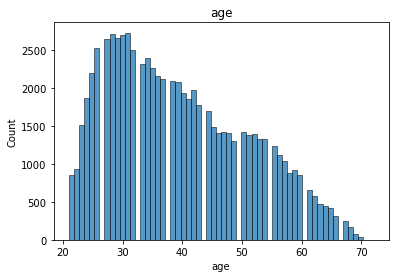

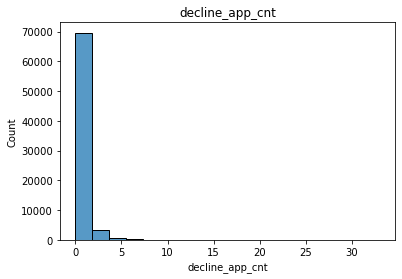

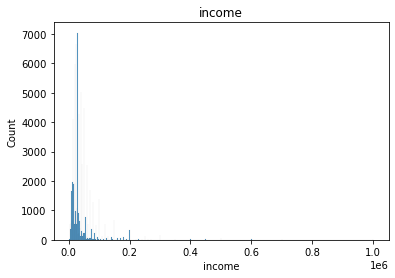

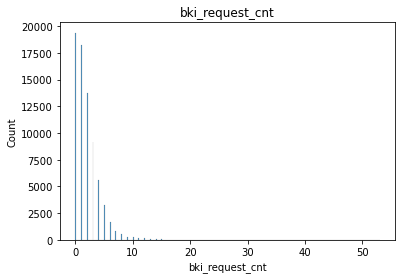

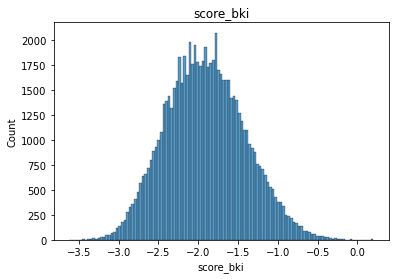

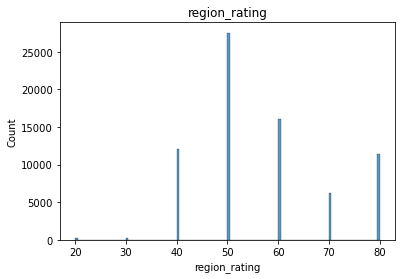

In [63]:
for i in num_cols:
    plt.figure()
    sns.histplot(train[i], kde = False,)
    plt.title(i)
    plt.show()

Признак score_bki распределен достаточно нормально, остальные признаки, возможно, требуют преобразования 

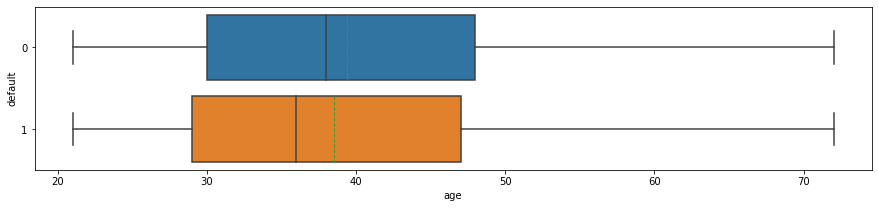

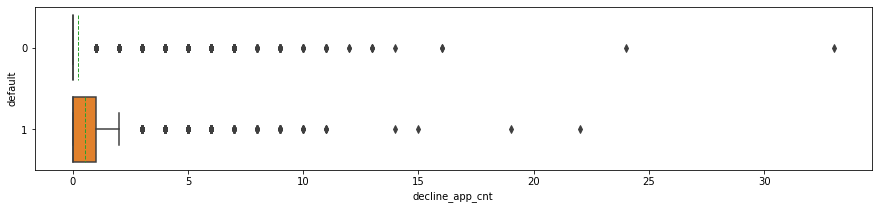

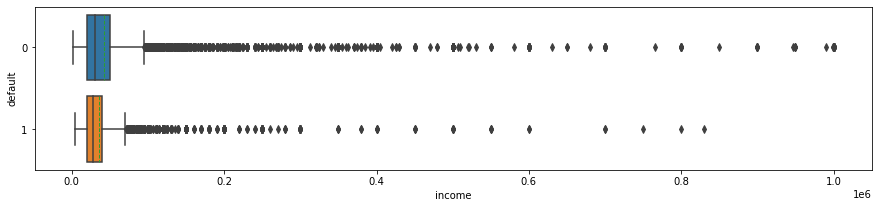

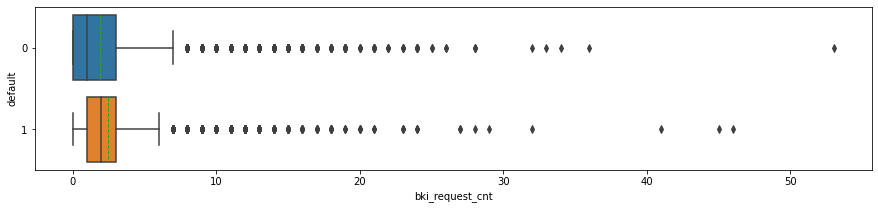

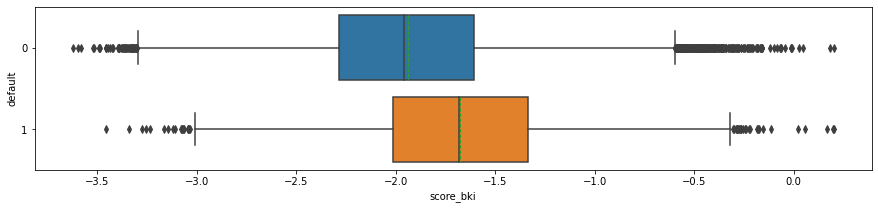

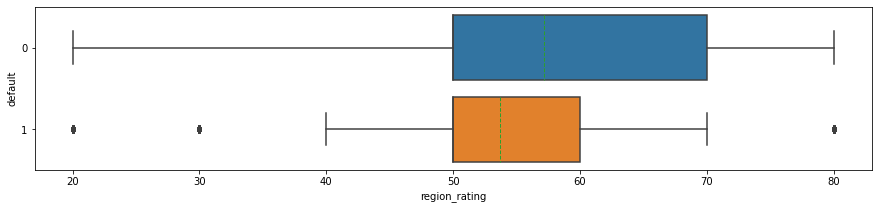

In [64]:
# Графики перед преобразованиями
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = train['default'], x = train[col],showmeans=True, meanline=True, orient='h')

Мы можем сделать следующие выводы: 
* Средний возраст клиентов, у которых был дефолт, ниже
* Клиенты, у которых не было дефолтов, в среднем почти не получали отказов в кредите, но были отдельные случаи
* Клиенты с дефолтами в среднем имеют более высокий показатель отказов, есть разница между квартилями
* Средний доход клиентов без дефолтов выше
* Средняя скоринга клиентов с дефолтами выше
* Средняя рейтинга регионов клиентов без дефолта выше, но также межквартильное расстояние больше
* Выбросы (беря внимание оба значения целевой переменной) есть у признаков:
    * score_bki
    * bki_request_cnt
    * income
    * decline_app_cnt

Изучим корреляции между числовыми признаками

<AxesSubplot:>

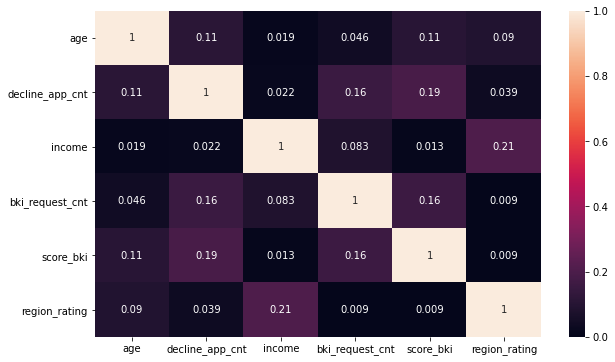

In [65]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Очень сильных корреляций между числовыми переменными нет. Самая большая связь наблюдается между доходом и рейтингом регионов, а также между скорингом банка и отказом в кредите

### Выбросы и новые переменные

In [66]:
# Ограничим выбросы в отказах до 8
train['decline_app_cnt'] = train['decline_app_cnt'].apply(lambda x: 8 if x  >=  8 else x)
# Создадим бинарную переменную, беря во внимание, что большое количество клиентов вообще не имеет отказов
train['decline_app_bin'] = train['decline_app_cnt'].apply(lambda x: 1 if x  >=  1 else 0)

In [67]:
# Создадим бинарный признак для доходов менее 25000 и более
train['income_bin'] = train['income'].apply(lambda x: 1 if x  < 25000  else 0)

In [69]:
# В признаках количества заявок на кредит и доходе имеет смысл ограничить значения до IQR
for col in ['bki_request_cnt','income',]:
    cut_IQR(col, train)

Обновим перечень типов переменных

In [70]:
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work','is_weekend',
            'start_month','decline_app_bin','income_bin']
# Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address','sna','first_time','month','day']
# Числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']

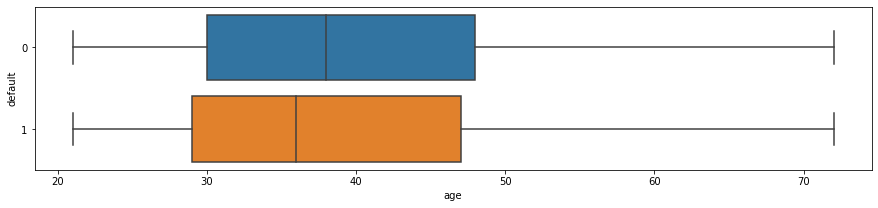

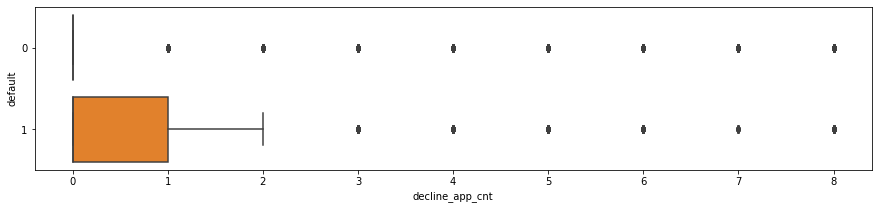

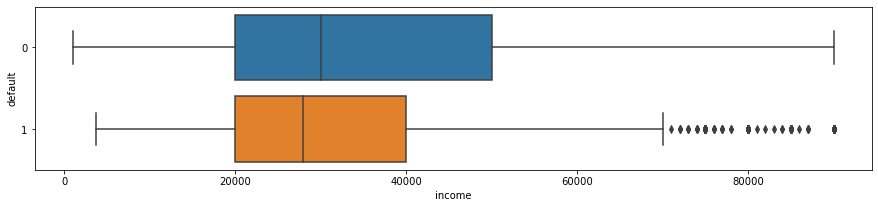

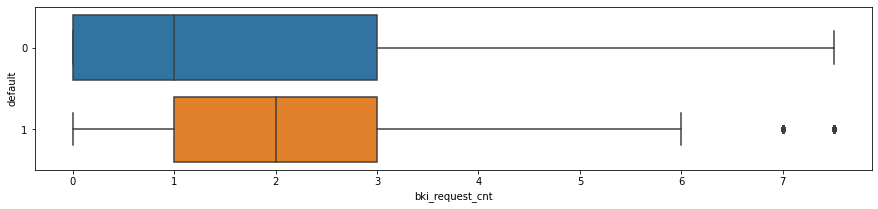

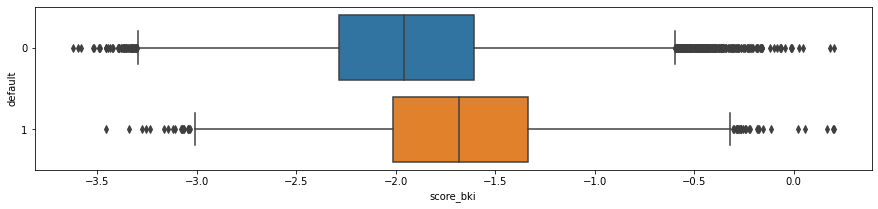

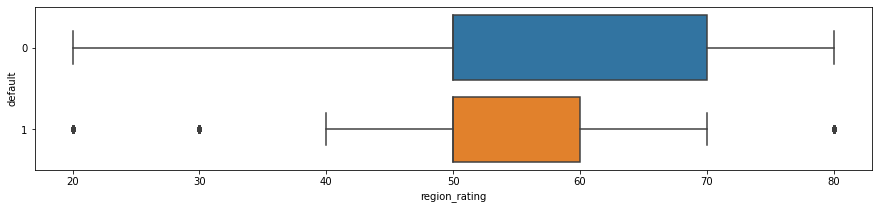

In [71]:
# Графики перед возможным логарифмированием
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = train['default'], x = train[col], orient='h')

На этом этапе оставим выбросы скоринга банка. Это, видимо, экперская оценка банка, нужен осторожный подход

<AxesSubplot:>

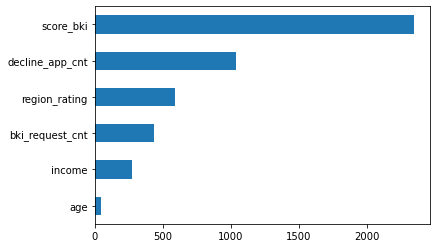

In [72]:
# Посмотрим на значимость влияния числовых факторов на целевую переменную
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Наиболее влиятельными являются скоринг банка и количество отказов в кредите

### Преобразования бинарных признаков

In [73]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])

<AxesSubplot:>

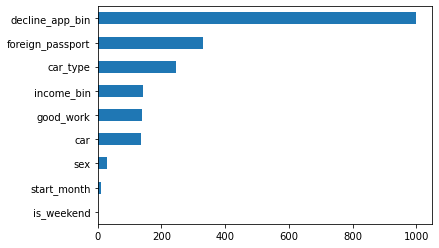

In [74]:
# Посмотрим на значимость бинарных переменных
imp_num = pd.Series(f_classif(train[bin_cols], train['default'])[0], index = bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самое сильное влияние оказывает отсутствие или наличие отказа в кредите. Сильно влияет наличие загранпаспорта, а также типа машины. Никак не влияет, была ли заявка составлена в выходные или нет. Этот признак не будет взят в расчет. Незначительное влияние оказывает, приходят ли клиенты в начале месяца или нет.

### Анализ категориальных признаков

Образование - это единственный признак, который содержит пропуски. В навной модели мы просто удалили пропуски

<AxesSubplot:>

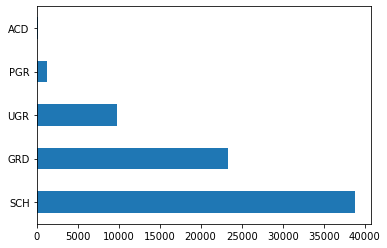

In [75]:
# Посмотрим распределение образования
train.education.value_counts().plot.barh()

In [76]:
# Считаем моду
mode_education  = train['education'].mode()[0]
# Заменим пропуски на моду
train['education'] = train['education'].apply(lambda x: mode_education if str(x) == 'nan' else x)

In [77]:
# Закодируем образование согласно степени образования
education_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 4, 'ACD': 5}
train.education = train.education.replace(education_dict)    

<AxesSubplot:>

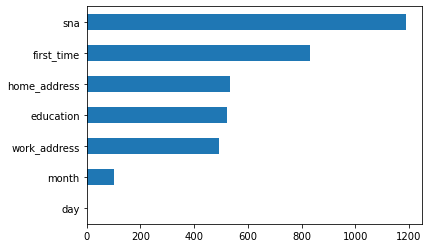

In [78]:
# Посмотрим на значимость категориальных переменных
imp_num = pd.Series(f_classif(train[cat_cols], train['default'])[0], index = cat_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

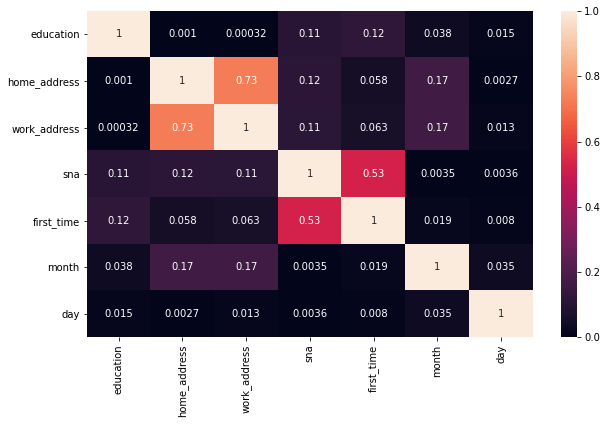

In [79]:
# Изучим взаимосвязи категориальных признаков
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(train[cat_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Самая сильная корреляция наблюдается между рабочим и домашним адресами. Также есть связь между связью заемщика и первой записью о заемщике в банке. Это было выявлено еще в PandasProfile. Дополнительных сильных корреляции не обнаружено.

<AxesSubplot:>

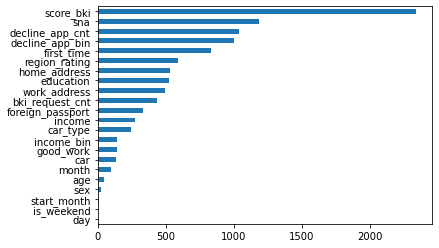

In [80]:
# Посмотрим на значимость всех переменных
imp_num = pd.Series(f_classif(train[cat_cols + num_cols + bin_cols], 
                              train['default'])[0], index = cat_cols + num_cols + bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Удалим 2 последние признака
### Окончательный список признаков
Этот список признаков был получен в результате экпериментов. Я добавлял и удалял различные признаки, модифицируя и возвращая предудущие, если они давали лучшие эффекты. Логарифмирование не принесло улучшения предсказаний, поэтому окончательно признаки не были логарифмированы.  

In [81]:
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work',
            'start_month','decline_app_bin','income_bin']
# Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address','sna','first_time','month',]
# Числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']

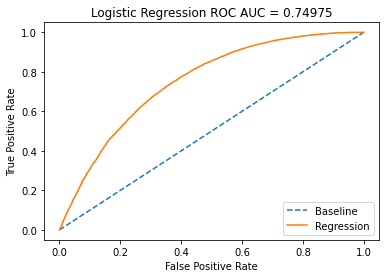

f1 score:= 0.6888
precision: 0.6817
recall: 0.6961
TP = 8976
TN = 8686
P = 12894
N = 12877
acc = 0.6853
Confusion matrix:
[[8686 4191]
 [3918 8976]]


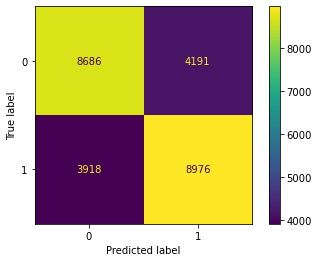

In [82]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_num = train[num_cols].values
X_bin = train[bin_cols].values

# Объединяем три типа данных в одну матрицу значений Х
X = np.hstack([X_num, X_bin, X_cat])
y = train['default'].values

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

# Делим данные
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.20,  random_state=42)

# Стандартизируем числовые переменные, записываем в матрицу X
scaler = StandardScaler()
# срез по столбцам от 0 до последнего числового, они у нас в самом начале массива стоят друг за другом
X_train[:,:len(num_cols)] = scaler.fit_transform(X_train[:,:len(num_cols)]) 
X_val[:,:len(num_cols)] = scaler.transform(X_val[:,:len(num_cols)])

# Обучаем модель только с указанием максимального значения итерации
model = LogisticRegression(max_iter=190)
model.fit(X_train, y_train)

# Предсказываем на разделенной выборке из train
y_pred_val = model.predict(X_val)
probs = model.predict_proba(X_val)
probs = probs[:,1]

# Выводим показатели
metrics(y_val, probs, y_pred_val)

Есть значительная разница по сравнению с наивной моделью. Из гиперпараметров пока использовано только максимальное значение итераций, найденно путем эксперементов. Попробуем настроить модель, используя GridSearchCV 

### Оптимизируем гиперпоказатели

In [46]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(max_iter=190)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on th

/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/anatolygusakov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on th

Лучшее Penalty: l2
Лучшее C: 464.15888336127773


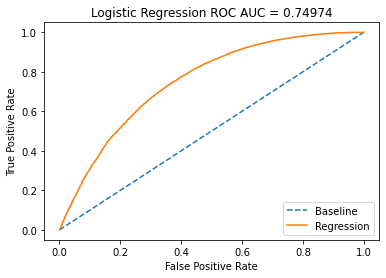

f1 score:= 0.6888
precision: 0.6817
recall: 0.6961
TP = 8975
TN = 8686
P = 12894
N = 12877
acc = 0.6853
Confusion matrix:
[[8686 4191]
 [3919 8975]]


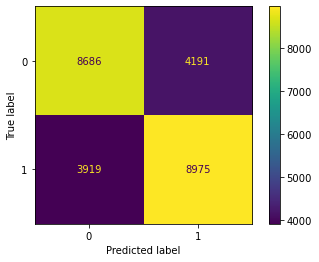

In [83]:
# Воспользуемся полученными гиперпоказатями

model = LogisticRegression(C=464.15888336127773,penalty='l2', max_iter=190)
model.fit(X_train, y_train)

# Предсказываем на разделенной выборке train
y_pred_val = model.predict(X_val)
probs = model.predict_proba(X_val)
probs = probs[:,1]

# Выводим показатели
metrics(y_val, probs, y_pred_val)

### Общая модель и тестовые данные для соревнования

In [85]:
# Применим преобразования к тестовой выборке

test.app_date = pd.to_datetime(test.app_date)
test['month'] = test.app_date.dt.month
test['start_month'] = test.app_date.dt.day < 7
test['decline_app_cnt'] = test['decline_app_cnt'].apply(lambda x: 8 if x  >=  8 else x)
test['decline_app_bin'] = test['decline_app_cnt'].apply(lambda x: 1 if x  >=  1 else 0)
test['income_bin'] = test['income'].apply(lambda x: 1 if x  < 25000  else 0)
for col in ['bki_request_cnt','income',]:
    cut_IQR(col, test)

bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work','start_month',
            'decline_app_bin','income_bin']
cat_cols = ['education', 'home_address','sna','work_address','first_time','month',]
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki','region_rating']    

label_encoder = LabelEncoder()
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])
mode_education  = test['education'].mode()[0]
test['education'] = test['education'].apply(lambda x: mode_education if str(x) == 'nan' else x)
education_dict = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 4, 'ACD': 5}
test.education = test.education.replace(education_dict)

In [86]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_num_test = test[num_cols].values
X_bin_test = test[bin_cols].values

# Объединяем три типа данных в одну матрицу значений Х
X_test = np.hstack([X_num_test, X_bin_test, X_cat_test])

# Стандартизируем
scaler = StandardScaler()
X_test[:,:len(num_cols)] = scaler.fit_transform(X_test[:,:len(num_cols)]) 

y_pred_test = model.predict(X_test)
probs_test = model.predict_proba(X_test)
probs_test = probs_test[:,1]

In [87]:
test['default'] = probs_test
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

client_id   default
29406       3989  0.211167
21495      44118  0.376749
15407      68122  0.574014
3256       41494  0.580717
240        97402  0.495378
10028      15975  0.556374
19342     107536  0.367357
35170     101316  0.353930
4714       97168  0.327099
22782      93200  0.410513

(36349, 2)

### Выводы:
* Для определения эффективности предсказаний недостаточно использовать ROC AUC, необходимо использовать f1 score, матрицу ошибок
* Индивидуальная обработка каждого признака приносит лучшие результаты, чем применение одинкового преобразования для всех признаков
* Создание дополнительных бинарных и ординальных признаков может сильно улучшить модель
* При большой диспропорции целевой переменной баланисирование выборки с помощью oversampling приносит значительное улучшение
* Настройка гиперпараметров не сильно улучшает показатели, но неправильно подобранные гиперпараметры могут ухудшить результат